<a href="https://colab.research.google.com/github/dla9944/2023_God_damn_deeplearning/blob/master/230125_Deeplearning_CRNN_Captcha_%EC%9E%84%EC%8B%9C%EC%A0%80%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU, 라이브러리 SETTING

In [30]:
# pytorch 라이브러리
import torch
import torchvision
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset
from torch import nn, optim
from torchvision import transforms, datasets
from torchvision.utils import save_image

# 시각화 관련

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm 
from PIL import Image

# arange 기본
import numpy as np
import pandas as pd
import  glob


# image convertor
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 그외

import os
import random
import string

In [31]:
# gpu 사용

USE_CUDA = torch.cuda.is_available()
DEVICE= torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using Device : {DEVICE}")

Using Device : cuda


# 데이터 로드
* 캡차 데이터셋
* https://www.kaggle.com/datasets/fournierp/captcha-version-2-images

In [32]:
# https://www.kaggle.com/{본인ID}/account
# 본인 프로필 누르고 > Account
# > Create New API Token > kaggle.json
from google.colab import files
!pip install -q kaggle #kaggle 설치 # --quiet
# -- kaggle api를 사용하기 위한 인증파일을 설정 (8-11)
files.upload() #kaggle API file upload
!mkdir ~/.kaggle # kaggle 디렉토리 생성 / mkdir : make directory - 폴더 생성 (~)
!cp kaggle.json ~/.kaggle/ #kaggle.json 파일 kaggle 폴더에 복사 / cp a b (copy)
!chmod 600 ~/.kaggle/kaggle.json # 권한 변경 r w x (4 2 1)
# ---------
# !kaggle datasets list #kaggle 데이터셋 리스트 체크
# https://www.kaggle.com/datasets/fournierp/captcha-version-2-images
# ... > Copy API command
!kaggle datasets download -d fournierp/captcha-version-2-images

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
captcha-version-2-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [33]:
# https://www.kaggle.com/datasets/fournierp/captcha-version-2-images
!kaggle datasets download -d salimwid/technology-company-layoffs-20222023-data

technology-company-layoffs-20222023-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [34]:
# 알집 압축 해제
!unzip /content/captcha-version-2-images.zip

Archive:  /content/captcha-version-2-images.zip
replace samples/226md.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [35]:
imgfile = sorted(glob.glob(
    'samples/*.png'
))
imgfile[0]

'samples/226md.png'

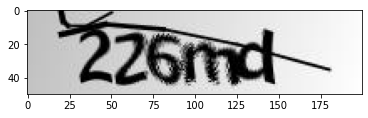

In [36]:
# image파일을 경로에 맞춰서 오픈할 수 있음
imageshow = Image.open(imgfile[0])
plt.imshow(imageshow)

## png 설명

* 이미지 파일의 확장자는 png
* png파일은 RGB채널 뿐만 아니라 투명도를 나타내는 알파 채널이 존재
* 일반적인 이미지 처리는 rgb를 가정하고 있기 때문에 이미지를 불러올 때
png파일은 rgb로 변환해야 함

# 학습용 데이터셋 만들기

## 파일 이름에 해당하는 부분이 입력해야 할 정답값
* 이름 그 자체는 의미값을 가지지 않음
* 따라서 파일 이름에서 확장자인 .png를 떼어내고 , 파일 이름만 정답으로 이용
* 정답에 등장하는 모든 문자들로부터 BOW를 만들어줘야함

## BOW를 만드는 함수

In [37]:
# 문자들로부터 BOW를 만드는 함수
def get_BOW(corpus):
    
    # 공백 문자 <pad>를 0으로 설정
    BOW = {'<pad>':0}

    # corpus의 문자들을 이용해서 BOW의 고유번호를 추가하기로 함
    for letter in corpus:
        if letter not in BOW.keys():
           BOW[letter]= len(BOW.keys())
    return BOW

# BOW 함수에 대해
get_BOW() 함수는 문자의 집합을 입력으로 받아서 bow를 반환하는 함수
* 먼저, 공백문자를 나타내는 토큰의 고유번호를 0으로 설정
* 모든 문자로부터 BOW를 생성하게 됨
* BOW에 들어있지 않는 문자의 고유번호를 CORPUS안에 들어있는 순서대로 설정

# 데이터셋 객체 정의

In [38]:
# capcha 데이터셋

class Captcha(Dataset):
   
   # 생성자
   def __init__(self, path, train= True):
        
         # path는 이미지 파일이 있는 폴더의 경로
         # train은 학습셋/ 시험셋 여부 결정
         super().__init__()

         # 소문자와 숫자만 정다븡로 이용
         self.corpus = string.ascii_lowercase + string.digits
         # ascii_lowercase =  일반적으로 사용하는 알파벳 소문자
         # digit = 10진법 숫자

         # 영어 소문자, 숫자로 만든 corpus로 BOW 업데이트
         self.BOW = get_BOW(self.corpus)

         # 불러올 이미지 파일의 경로
         self.imgfiles = sorted(glob.glob(path+'/*.png'))

         # 훈련셋/시험셋 -> 전체 이미지 파일 중에 80%는 훈련셋, 20%는 시험셋
         self.train = train
         self.trainset = self.imgfiles[:int(len(self.imgfiles)*0.8)]
         self.testset = self.imgfiles[int(len(self.imgfiles)*0.8):]

   # captcha의 문자(파일명)으로부터 정답(고유번호) 생성하는 함수
   def get_seq(self, line):
       label = []
       for letter in line:
           label.append(self.BOW[letter])   
       return label

   # 데이터 갯수를 반환하는 함수 __len__
   def __len__(self):
       if self.train:
          return len(self.trainset)
       else:
          return len(self.testset)
    
   # 학습용 데이터를 처리
   def __getitem__(self, i):
        if self.train:

           # png파일을 RGB 채널로 변환
           data = Image.open(self.trainset[i]).convert('RGB')
           
           # 경로를 '/' 단위로 split
           label = self.trainset[i].split('/')[-1]

           # 파일이름에서 확장자를 제거
           label = label.replace('.png', '')

           # BOW의 순열 → 고유번호 리스트. 숫자표현으로 바뀌게 됨
           label = self.get_seq(label)

           # 이미지 처리(+numpy 배열로 변환)
           # PIL(가로, 세로, RGB채널) → pytorch(RGB채널, 가로, 세로)
           data = np.array(data).astype(np.float32)

           # transpose(전치)
           data = np.transpose(data, (2, 0, 1))

           # A 배열의 차원 순서를 'shape'가 되도록 변경하기 = np.transpose(A, shape)
           label = np.array(label)

           return data, label

        # 시험셋 데이터를 처리할 때
        else: 
            # 시험용 데이터를 처리하는 코드(위와 거의 동일함)
            data = Image.open(self.testset[i]).convert('RGB')

            label = self.trainset[i].split("/")[-1]
            label = label.replace(".png", "")
            label = self.get_seq(label)

            data = np.array(data).astype(np.float32)
            data = np.transpose(data, (2, 0, 1))

            label = np.array(label)
            return data, label

# 모델 정의

## 기본 블록 정의

In [50]:
# CRNN 모델 3x5 사이즈 커널 이용
class BasicBlock(nn.Module):
   def __init__(self, in_channels, out_channels, kernel_size = (3,5), stride = (2,1)):
       super(BasicBlock, self).__init__()
       
       # 합성곱 레이어는 2개 → 커널 크기가 다름
       # 첫번째 합성곱 : 가로 길이 > 세로 길이 (3x5)
       self.c1 = nn.Conv2d(in_channels=in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride)
       
       # 두번째 합성곱 : 가로 길이 = 세로 길이 (정사각형)
       self.c2 = nn.Conv2d(in_channels=out_channels, out_channels = out_channels, kernel_size = (3,3), padding = 1)
       
       # Resnet 사용할 예정 : 원본 다운 샘플링
       self.downsample = nn.Conv2d(in_channels=in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride)

       # batch normalize를 통한 overfitting 방지함
       self.bn1 = nn.BatchNorm2d(num_features = out_channels)
       self.bn2 = nn.BatchNorm2d(num_features = out_channels)

       # Activation function
       self.ReLU = nn.ReLU()

   # Resnet의 forward propagation 정의
   # convolution & batch normalization & x와 x_(원본)을 더해서 출력할 예정
   def forward(self, x):
       
       # 임시저장
       x_ = x 

       x = self.c1(x)
       x = self.bn1(x)
       x = self.ReLU(x)
       x = self.c2(x)
       x = self.bn2(x)

       x_ = self.downsample(x_)

       x += x
       x = self.ReLU(x)

       return x

In [61]:
# torchsummary로 신경망 계층 정보확인
import torchsummary

myBasicBlock = BasicBlock(16, 5).to(DEVICE)
torchsummary.summary(myBasicBlock, (16, 200, 50) ,16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [16, 5, 99, 46]           1,205
       BatchNorm2d-2            [16, 5, 99, 46]              10
              ReLU-3            [16, 5, 99, 46]               0
            Conv2d-4            [16, 5, 99, 46]             230
       BatchNorm2d-5            [16, 5, 99, 46]              10
            Conv2d-6            [16, 5, 99, 46]           1,205
              ReLU-7            [16, 5, 99, 46]               0
Total params: 2,660
Trainable params: 2,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 9.77
Forward/backward pass size (MB): 19.46
Params size (MB): 0.01
Estimated Total Size (MB): 29.23
----------------------------------------------------------------
